# Binomial sampling engine

The basic idea is that a 2D rectangular grid with periodic boundary conditions is used as our domain for binomial subsampling and advection

Since this is intended as a cheap toy model, we store the full time evolution in a single matrix N(xdim,ydim,sizebins,timesteps) which is a integer array of how many samples of a sizebin are at each grid point at each point of time


## This notebook should contain pretty much everything needed for binomial subsampling paper!

## Contents 

* initialization of field and all parameters
* time stepping
* 2D advection (Without time decay for the mean time)
* clustering subroutines for postprocessing only (add_buffer and cluster_2D)
* plotting and movie making cells

## Ideas

* Make birthrate probability of plumes zero if no no plumes one step smaller exist, see if you get time evolution. But should severly limit amount of large clouds, so the background birthrate is no longer preserved. 


## Updates 

RN, 20200303: Demographics dimension added to N, containing an integer number of age strata. This allows a very straightforward discrete representation of object births and deaths: 
* Every timestep, the oldest (boomer) layer is just pushed "one step beyond" and forgotten;
* New births are simply inserted into the youngest (Gen Z or Millenial) layer of the demographics array.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from random import random
import matplotlib
from netCDF4 import Dataset
import matplotlib.cm as cm
import matplotlib.pyplot as plt    # The code below assumes this convenient renaming
import math
import seaborn as sns
sns.set()

import sys 
import pandas as pd

In [2]:
# generating random colormap for clustering plotting
colors = [(0.5,0.5,0.5)] + [(random(),random(),random()) for i in range(1000)]
random_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('random_cmap', colors, N=1000)

In [3]:
#for dealing with periodic boundary conditions
def add_buffer(A,n_extra):
    """Adds n_extra cells/columns in x and y direction to array A. Works with 2d and 3d arrays, super advanced stuff right here. """
    if A.ndim == 2:
        A_extra = np.vstack([A[-n_extra:,:],A,A[:n_extra,:]])
        A_extra = np.hstack([A_extra[:,-n_extra:],A_extra,A_extra[:,:n_extra]])
    if A.ndim == 3:
        A_extra = np.concatenate((A[:,-n_extra:,:],A,A[:,:n_extra,:]),axis=1)
        A_extra = np.concatenate((A_extra[:,:,-n_extra:],A_extra,A_extra[:,:,:n_extra]),axis=2)
        
    
    return A_extra
 



In [4]:
#as the name applies
def cluster_2D(A,buffer_size=30 ):
    """
    For Linnea, isn't pretty. 
    
    Uses inefficient np.where, but should be fine for 2D
    
    A is 2D matrix of 1 (cloud) and 0 (no cloud)
    buffer_size is the percentile added to each side to deal with periodic boundary domains
    
    returns labeled_clouds, is 0 where no cloud
    """
    #Uses a default periodic boundary domain
    n_max = A.shape[0]
 
    n_buffer = int(buffer_size/100.*n_max)

    #Explanding c and w fields with a buffer on each edge to take periodic boundaries into account. 
    A_buf=add_buffer(A,n_buffer)
    
    #labeled_clouds  = np.zeros_like(A_buf)
    
    #This is already very impressive, ndi.label detects all areas with marker =1 that are connected and gives each resulting cluster an individual integer value 
    labeled_clouds,n_clouds  = ndi.label(A_buf)
    
    
    
    #Going back from the padded field back to the original size
    # OK, calculate index means, then only look at those with a mean inside the original box
    # We ignore the cells with the mean outside, they will be cut off or overwritten
    # For those inside we check if they have something outside original box, and if so a very ugly hard coded overwritting is done. 
    # In the very end the segmentation box is cut back down to the iriginal size

    
    
    
    #fancy quick sorting. 
    unique_labels, unique_label_counts = np.unique(labeled_clouds,return_counts=True)
    lin_idx       = np.argsort(labeled_clouds.ravel(), kind='mergesort')
    lin_idx_split = np.split(lin_idx, np.cumsum(np.bincount(labeled_clouds.ravel())[:-1]))
    
    for c in range(1,n_clouds+1): 
        idx_x,idx_y = np.unravel_index(lin_idx_split[c],labeled_clouds.shape)
    
    

        #idx_x,idx_y = np.where(labeled_clouds==c)
        idx_x_m = np.mean(idx_x)
        idx_y_m = np.mean(idx_y)

        if idx_x_m< n_buffer or idx_x_m>n_buffer+n_max or idx_y_m< n_buffer or idx_y_m>n_buffer+n_max:
            #cluster is outside, chuck it
            #print(c,'cluster out of bounds',idx_x,idx_y)
            #segmentation_cp[segmentation==c] = 0
            bla = 1

        else:
            idx_x_max = np.max(idx_x)
            idx_x_min = np.min(idx_x)
            idx_y_min = np.min(idx_y)
            idx_y_max = np.max(idx_y)
            if idx_x_min< n_buffer or idx_x_max>n_buffer+n_max or idx_y_min< n_buffer or idx_y_max>n_buffer+n_max:
                #print(c,'this is our guniea pig')
                if idx_x_min<n_buffer:
                    idx_x_sel = idx_x[idx_x<n_buffer]+n_max
                    idx_y_sel = idx_y[idx_x<n_buffer]
                    labeled_clouds[idx_x_sel,idx_y_sel] = c
                if idx_x_max>=n_buffer+n_max:
                    idx_x_sel = idx_x[idx_x>=n_buffer+n_max]-n_max
                    idx_y_sel = idx_y[idx_x>=n_buffer+n_max]
                    labeled_clouds[idx_x_sel,idx_y_sel] = c
                if idx_y_min<n_buffer:
                    idx_x_sel = idx_x[idx_y<n_buffer]
                    idx_y_sel = idx_y[idx_y<n_buffer]+n_max
                    labeled_clouds[idx_x_sel,idx_y_sel] = c
                if idx_y_max>=n_buffer+n_max:
                    idx_x_sel = idx_x[idx_y>=n_buffer+n_max]
                    idx_y_sel = idx_y[idx_y>=n_buffer+n_max]-n_max
                    labeled_clouds[idx_x_sel,idx_y_sel] = c



    #Now cut to the original domain
    labeled_clouds_orig = labeled_clouds[n_buffer:-n_buffer,n_buffer:-n_buffer]
    
    #And to clean up the missing labels 
    def sort_and_tidy_labels_2D(segmentation):
        """
        For a given 2D integer array sort_and_tidy_labels will renumber the array 
        so no gaps are between the the integer values and replace them beginning with 0 upward. 
        Also, the integer values will be sorted according to their frequency. 
        
        1D example: 
        [4,4,1,4,1,4,4,3,3,3,3,4,4]
        -> 
        [0,0,2,0,2,0,0,1,1,1,1,0,0]
        """
       
        unique_labels, unique_label_counts = np.unique(segmentation,return_counts=True)
        n_labels = len(unique_labels)
        unique_labels_sorted = [x for _,x in sorted(zip(unique_label_counts,unique_labels))][::-1]
        new_labels = np.arange(n_labels)
       
        lin_idx       = np.argsort(segmentation.ravel(), kind='mergesort')
        lin_idx_split = np.split(lin_idx, np.cumsum(np.bincount(segmentation.ravel())[:-1]))
        #think that I can now remove lin_idx, as it is an array with the size of the full domain. 
        del(lin_idx)
       
        for l in range(n_labels):
            c = unique_labels[l]
            idx_x,idx_y = np.unravel_index(lin_idx_split[c],segmentation.shape)
            segmentation[idx_x,idx_y] = new_labels[l]
       
        return segmentation 
    

    labeled_clouds_clean = sort_and_tidy_labels_2D(labeled_clouds_orig)
    
    
    return labeled_clouds_clean



    

In [5]:
## binning functions

In [6]:
def log_binner_minmax(var, bin_min, bin_max, bin_n, N_min=0):
    """
    written by Lennéa Hayo, 19-07-20
    
    Bins a vector of values into logarithmic bins
    Starting from bin_min and ending at bin_max
    
    Parameters:
        var: input vector
        bin_min: value of the first bin
        bin_max: value of the last bin
        bin_n: number of bins 
        
    Returns:
        bins: vector of bin edges, is bin_n+1 long
        ind: gives each value of the input vector the index of its respective bin
        CSD: Non normalized distribution of var over the bins. 
    """
    import numpy as np

    max_val = max(var)
    min_val = min(var)
    #bin_min = max(min_val, bin_min)
    #bin_max = min(max_val, bin_max)

    max_log = np.log10(bin_max / bin_min)

    bins = bin_min * np.logspace(0, max_log, num=bin_n + 1)
    ind = np.digitize(var, bins)
    CSD = np.zeros(bin_n)
    for b in range(bin_n):
        if len(ind[ind == b + 1]) > N_min:
            CSD[b] = float(np.count_nonzero(ind == b + 1)) / (bins[b + 1] - bins[b])
        else:
            CSD[b] = 'nan'
    return bins, ind, CSD 


In [7]:
def lin_binner_minmax(var, bin_min, bin_max, bin_n, N_min=0):
    """
    written by Philipp Griewank 20-01-21
    
    Bins a vector of values into linear bins
    Starting from bin_min and ending at bin_max
    
    Parameters:
        var: input vector
        bin_min: value of the first bin
        bin_max: value of the last bin
        bin_n: number of bins 
        
    Returns:
        bins: vector of bin edges, is bin_n+1 long
        ind: gives each value of the input vector the index of its respective bin
        CSD: Non normalized distribution of var over the bins. 
    """
    import numpy as np

    max_val = max(var)
    min_val = min(var)
    #bin_min = max(min_val, bin_min)
    #bin_max = min(max_val, bin_max)


    bins = np.linspace(bin_min, bin_max, num=bin_n + 1)
    ind = np.digitize(var, bins)
    CSD = np.zeros(bin_n)
    for b in range(bin_n):
        if len(ind[ind == b + 1]) > N_min:
            CSD[b] = float(np.count_nonzero(ind == b + 1)) / (bins[b + 1] - bins[b])
        else:
            CSD[b] = 'nan'
    return bins, ind, CSD 


In [8]:
def func_scatter_grid(N_2D,buffer=0.1):
    """
    Just used for fancy plotting. 
    
    Buffer is how much space is left around the end
    """

    x_rand_grid = np.zeros(0)
    y_rand_grid = np.zeros(0)
    n_width,n_height = N_2D.shape
    for i in range(n_width):
        for j in range(n_height):
            x_rand_grid = np.hstack([x_rand_grid,np.zeros(N_2D[i,j])+i])
            y_rand_grid = np.hstack([y_rand_grid,np.zeros(N_2D[i,j])+j])

    x_rand_grid = x_rand_grid + np.random.random(len(x_rand_grid))*(1-2*buffer)+buffer
    y_rand_grid = y_rand_grid + np.random.random(len(y_rand_grid))*(1-2*buffer)+buffer
    return x_rand_grid,y_rand_grid    

# Advection baby

This is a bit trickier. The base idea is that a discrete upwind advection can be achieved by using np.random.binomial to determine how many plumes of one cell are advected to the next. The probability of being drawn is equal to the area of the cell that would be advected beyond it's eulerian boundaries. This implies that the samples are equally distributed in the cell

To make sure that when drawing advection samples for multiple directions, make sure to adjust the number of samples still in the domain, and the ratio of the advective domain to the not yet sampled domain. For example lets say we have a full domain size A_sub = dx_sub dx_sub. And the Area the domain would be advected into the x direction is A_x, in y is A_y, and over the corner is A_xy. If we start drawing how many samples are advected to A_x (N_x), 
N_x = np.random.binomial(N_sub,A_x/A_sub)

If we then draw for the y direction 
N_y = np.random.binomial(N_sub-N_x,A_y/(A_sub-A_x))




In [9]:
def func_advection_binomial_2D(N_sub_2D_t0,v_x_rel,v_y_rel,periodic_flag = True):
    """
    Lets see if we go with peridiotic boundaries domain
    
    First go in x, than in y, then in xy directions. probabilities p are calculated accordingly
    
    Now includes periodic boundary conditions, automaticall checks for conservation.
    
    x and y winds may not be negative!
    
    """
   
    #This wasn't really carefully thought through, but I think it should be correct
    A_x  = v_x_rel-v_x_rel*v_y_rel
    A_y  = v_y_rel-v_x_rel*v_y_rel
    A_xy = v_y_rel*v_x_rel
    A = 1
    p_x  = A_x/A
    p_y  = A_y/(A-A_y)
    p_xy = A_xy/(A-A_x-A_y)
    
    #Now do and x, y, and xy separately, and loop over all N_sub
    N_x  = np.zeros_like(N_sub_2D_t0)
    N_y  = np.zeros_like(N_sub_2D_t0)
    N_xy = np.zeros_like(N_sub_2D_t0)
    #x direction
    N_x  = np.random.binomial(N_sub_2D_t0,p_x)
    N_y  = np.random.binomial(N_sub_2D_t0-N_x,p_y)
    N_xy = np.random.binomial(N_sub_2D_t0-N_x-N_y,p_xy)
    
    N_sub_2D_t1 = N_sub_2D_t0 +0
#     N_sub_2D_t1[1: ,:] = N_sub_2D_t1[1: ,:] + N_x[:-1,:] 
#     N_sub_2D_t1[:-1,:] = N_sub_2D_t1[:-1,:] - N_x[:-1,:] 
#     N_sub_2D_t1[:,1: ] = N_sub_2D_t1[:,1: ] + N_y[:,:-1] 
#     N_sub_2D_t1[:,:-1] = N_sub_2D_t1[:,:-1] - N_y[:,:-1] 
#     N_sub_2D_t1[1: ,1: ] = N_sub_2D_t1[1: ,1: ] + N_xy[:-1,:-1] 
#     N_sub_2D_t1[:-1,:-1] = N_sub_2D_t1[:-1,:-1] - N_xy[:-1,:-1] 
    
    N_sub_2D_t1[1: ,:] = N_sub_2D_t1[1: ,:] + N_x[:-1,:] 
    N_sub_2D_t1[:,1: ] = N_sub_2D_t1[:,1: ] + N_y[:,:-1] 
    N_sub_2D_t1[1: ,1: ] = N_sub_2D_t1[1: ,1: ] + N_xy[:-1,:-1] 
    
    
    N_sub_2D_t1[:,:] = N_sub_2D_t1[:,:] - N_x[:,:] 
    N_sub_2D_t1[:,:] = N_sub_2D_t1[:,:] - N_y[:,:] 
    N_sub_2D_t1[:,:] = N_sub_2D_t1[:,:] - N_xy[:,:] 
    if periodic_flag==True: 

        #periodic boundaries in x and y is easy
        N_sub_2D_t1[0 ,:] = N_sub_2D_t1[0 ,:] + N_x[-1,:] 
        N_sub_2D_t1[:,0 ] = N_sub_2D_t1[:,0 ] + N_y[:,-1]

        #for xy is a pain in the ass. Needs the first row, first column, and 0,0 thing separately
        N_sub_2D_t1[0  ,1: ] = N_sub_2D_t1[0 ,1: ] + N_xy[-1,:-1] 
        N_sub_2D_t1[1: , 0 ] = N_sub_2D_t1[1: ,0 ] + N_xy[:-1,-1] 
        N_sub_2D_t1[0  , 0 ] = N_sub_2D_t1[0 ,0 ] + N_xy[-1,-1] 

        #print(np.sum(N_sub_2D_t0))
        #print(np.sum(N_sub_2D_t1))
        if np.sum(N_sub_2D_t0) != np.sum(N_sub_2D_t1):
            print('wtf! No advection conservation')

    return N_sub_2D_t1

# Time stepping

In [10]:
def func_timestepping():
    """
    Runs timestepping, but needs everything to have already been defined previously in the settings cell.
    
    Has discrete death (through demographics)
    """

    #--- time loop ----
    for t in range(ntim):


        #--- size loop ---
        for l in range(nsiz):

            
            #--- Object birthdays! Time-shift of the demographics levels ---
            for i in range(nage-1,0,-1):
                N[:,:,l,t,i] = N[:,:,l,t-1,i-1]   #note: oldest level is forgotten
            
            
            #--- Probability of birth p ---
            if pulse_growth_flag:
                
                dp_pulse[:,:] = 0.

                #--- Adjust p under certain rules ---
                
                # Rule 1: pulsating growth
                for i in range(len(x)):
                    for j in range(len(y)):
                        xr = np.array( range(i-nx_pulse,i+nx_pulse+1) )
                        xr = np.where(xr < 0  , xr+nx, xr)
                        xr = np.where(xr >= nx, xr-nx, xr)
                        yr = np.array( range(j-ny_pulse,j+ny_pulse+1) )
                        yr = np.where(yr < 0  , yr+ny, yr)
                        yr = np.where(yr >= ny, yr-ny, yr)
                        submesh = np.ix_( xr, yr )
                        #print( submesh)
                        dp_pulse[submesh] = dp_pulse[submesh] + f_pulse[:,:] * np.sum(N[i,j,l,t,:])
                    

                p[:,:,l,t] = p[:,:,l,t] + prob_sub * dp_pulse[:,:] * fac_pulse

                # Rule 2: environmental deformation, so that average birth rate is conserved at prob_sub
                if np.mean(p[:,:,l,t])>0.:
                    #print( np.mean(p[:,:,l,t]) )
                    fac_p = prob_sub / np.mean(p[:,:,l,t])
                    p[:,:,l,t] = p[:,:,l,t] * fac_p


            #--- Births ---
            B = np.random.binomial(N_tot_ref[l], p[:,:,l,t].ravel(), nx*ny)
            B = B.reshape([nx,ny])
            # Warning! Need to make sure that the resizing is done correctly, so that x and y aren't swapped accidentally

            
            #--- Update object number ---
            N[:,:,l,t,0] = B    # add births as level 1 demographics
            
            
            print( "t=%s  time = %s" % (t, t*dtim),' sizebin' ,l,'max birth: ',np.max(B),np.max(N[:,:,l,t,0]))

        
    return N, p, dp_pulse


# Settings  and initialization

In [11]:


#--- Grid parameters ----------
nx   = 100     #grid size
ny   = 100
nsiz = 1       #nr of sizes in spectrum

#ntim = 10     #nr of timesteps
#ntim = 12*60    #nr of timesteps  12 hours
ntim = 24*60    #nr of timesteps  12 hours

nage = 1        #dimension of thermal demographics: number of thermal age strata

dx   = 100.    #x gridspacing     [m]
dy   = 100.     #y gridspacing     [m]
dsiz = 100.    #width of size bin [m]
dtim = 60.     #time increment    [s]

#--- Reference domain
L_ref    = 1000000.   #size of very large reference domain  [m]
dt_ref   = dtim       #timestep of very large ref domain    [s]

#--- birth and lifetime constants --------
B_0  = np.zeros(nsiz)
B_0[:]    = 2.e-7   #average nr of object births / m2 / s

tau_D     = 300.    #object life time  [s]
#tau_D     = 150.    #object life time  [s]
tau_D_dt  = int(tau_D/dtim) #object life time in timesteps []

nage = int(tau_D/dtim)   #demographics: number of object age strata

#--- pulsating growth parameters
pulse_growth_flag = 1
r_pulse   = 300.    #radius of impact cone of pulsating growth  [m]
#fac_pulse =   40.    #factor of proportionality in impact of pulsating growth on p
fac_pulse = 2000.    

#--- Advection parameters
u  = 5. #x wind, used for advection [m/s]
v  = 5. #y wind, used for advection [m/s]




#--- declare arrays -----------
x    = ( np.array(range(nx  )) + 0.5) * dx
y    = ( np.array(range(ny  )) + 0.5) * dy
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
tim  = ( np.array(range(ntim)) + 0.5) * dtim

N        = np.zeros( (nx,ny,nsiz,ntim,nage) ).astype(int)    #array containing object number
p        = np.empty( (nx,ny,nsiz,ntim) )    #array containing object birth probability
dp_pulse = np.empty( (nx,ny) )    #perturbation in p due to pulsating growth (rule 1)




#--- binomial probability values -----------
N_tot_ref = np.zeros(nsiz)
N_tot_ref[:] = (B_0[:]*L_ref*L_ref*dt_ref).astype(int)  #total nr of objects born in reference domain
#print( N_tot_ref[0] )

prob_sub = dx*dy*dtim/(dt_ref*L_ref*L_ref)     #probability that one of N_tot_ref births happens in a gridbox
print( "prob_sub=%s" % (prob_sub) )

p[:,:,:,:] = prob_sub

for i in range(len(siz)):
    print( "size=%s B0=%s N_tot_ref=%s" % (siz[i],B_0[i],N_tot_ref[i]) )

    
#--- set up pulsating growth stuff ---   
print(pulse_growth_flag)

if pulse_growth_flag:
    nx_pulse = np.int( r_pulse / dx)
    ny_pulse = np.int( r_pulse / dy)

    f_pulse  = np.empty( (2 * nx_pulse + 1, 2 * ny_pulse + 1) )  

    for i in range(f_pulse.shape[0]):
        for j in range(f_pulse.shape[0]):
            f_pulse[i,j] = np.max( [0., 1. - ( (dx * (i - nx_pulse))**2 + (dy * (j - ny_pulse))**2 )**0.5 / r_pulse ] )

prob_sub=1e-08
size=50.0 B0=2e-07 N_tot_ref=11999999.0
1


# Now the fun starts!

In [12]:
N, p, dp_pulse = func_timestepping()

('t=0  time = 0.0', ' sizebin', 0, 'max birth: ', 3, 3)
('t=1  time = 60.0', ' sizebin', 0, 'max birth: ', 4, 4)
('t=2  time = 120.0', ' sizebin', 0, 'max birth: ', 3, 3)
('t=3  time = 180.0', ' sizebin', 0, 'max birth: ', 4, 4)
('t=4  time = 240.0', ' sizebin', 0, 'max birth: ', 4, 4)
('t=5  time = 300.0', ' sizebin', 0, 'max birth: ', 3, 3)
('t=6  time = 360.0', ' sizebin', 0, 'max birth: ', 4, 4)
('t=7  time = 420.0', ' sizebin', 0, 'max birth: ', 3, 3)
('t=8  time = 480.0', ' sizebin', 0, 'max birth: ', 4, 4)
('t=9  time = 540.0', ' sizebin', 0, 'max birth: ', 3, 3)
('t=10  time = 600.0', ' sizebin', 0, 'max birth: ', 3, 3)
('t=11  time = 660.0', ' sizebin', 0, 'max birth: ', 4, 4)
('t=12  time = 720.0', ' sizebin', 0, 'max birth: ', 3, 3)
('t=13  time = 780.0', ' sizebin', 0, 'max birth: ', 3, 3)
('t=14  time = 840.0', ' sizebin', 0, 'max birth: ', 3, 3)
('t=15  time = 900.0', ' sizebin', 0, 'max birth: ', 3, 3)
('t=16  time = 960.0', ' sizebin', 0, 'max birth: ', 3, 3)
('t=17  ti

## Save N field to netcdf file

In [15]:
#nage = int(tau_D/dtim)   #demographics: number of object age strata
#x    = ( np.array(range(nx  )) + 0.5) * dx
#y    = ( np.array(range(ny  )) + 0.5) * dy
#siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
#tim  = ( np.array(range(ntim)) + 0.5) * dtim
#
#N        = np.zeros( (nx,ny,nsiz,ntim,nage) ).astype(int)    #array containing object number


import datetime

fnameout = "N_thermals.nc"

out = Dataset(fnameout, 'w', format='NETCDF4')
print("writing to file: " + fnameout)


out.creator     = "Roel Neggers, IGMK, University of Cologne"
out.created     = datetime.datetime.today().strftime('%d %b %Y')


xdim    = out.createDimension('nx'    , nx)
ydim    = out.createDimension('ny'    , ny)
sizdim  = out.createDimension('nsiz'  , nsiz)
timdim  = out.createDimension('ntim'  , ntim)
agedim  = out.createDimension('nage'  , nage)


out_x = out.createVariable('x', np.float32, ('nx'))
out_x.units = 'm'
out_x.long_name = 'gridsize in x direction'

out_y = out.createVariable('y', np.float32, ('ny'))
out_y.units = 'm'
out_y.long_name = 'gridsize in y direction'

out_siz = out.createVariable('siz', np.float32, ('nsiz'))
out_siz.units = 'm'
out_siz.long_name = 'object size'

out_tim = out.createVariable('time', np.float32, ('ntim'))
out_tim.units = 's'
out_tim.long_name = 'time'

out_age = out.createVariable('age', np.int32, ('nage'))
out_age.units = 'index'
out_age.long_name = 'age stratum'


out_N  = out.createVariable('N', np.int32, ('nx','ny','nsiz','ntim','nage'))
out_N.units = 'count'
out_N.long_name = 'object number'

out_x  [:] = x
out_y  [:] = y
out_siz[:] = siz
out_tim[:] = tim
out_age[:] = range(nage)

out_N[:,:,:,:,:] = N[:,:,:,:,:]

out.close()


writing to file: N_thermals.nc


## 2D scatter plots

Multi species (size density)

Random placement within gridbox

ntim2: timestep of interest

change time loop as desired


In [51]:
from matplotlib.ticker import MultipleLocator

#sizes = siz**2/1000
#color = ['k','b','orange','r','g']
#buff  = ['k','b','orange','r']
sizes = (2*siz)**2/2000
print(sizes)


#color = ['b','orange','r','g']
color = ['tab:blue','tab:green','tab:olive','tab:orange','tab:red','tab:purple','purple','black']
ncol = len(color)

#ncol = 10
import matplotlib.pylab as pl
#colors = pl.cm.Paired(np.linspace(0,1,ncol))
#colors = pl.cm.tab10(np.linspace(0,1,ncol))
#color = pl.cm.summer(np.linspace(0,1,ncol))
#color = pl.cm.winter(np.linspace(0,1,ncol))
#color = pl.cm.terrain(np.linspace(0,1,ncol))
#color = pl.cm.gist_earth(np.linspace(0,1,ncol))
#color = pl.cm.jet(np.linspace(0,1,ncol))
#color = pl.cm.RdBu_r(np.linspace(0,1,ncol))
#color = pl.cm.viridis(np.linspace(0,1,ncol))
#color = pl.cm.coolwarm(np.linspace(0,1,ncol))
#color = pl.cm.BuGn(np.linspace(0,1,ncol))
#print(color)


#outdir_mov = 'mov/'
outdir_mov = 'mov_thermals/'


figsize=(12,12)


#ext = ".png"
ext = ".pdf"


print('starting.. ')

#ntim2 = ntim
#ntim2 = 12*3600/60
ntim2 = 18*3600/60
#ntim2 = 24*3600/60
print(ntim2)

#for t in range (ntim2):
for t in range (ntim2-1,ntim2):
    
    fig = plt.figure(figsize=figsize)

    axes = plt.gca()
    #axes.set_aspect('equal')

    axes.set_xlim([0,nx*dx])
    axes.set_ylim([0,ny*dy])

    axes.xaxis.set_major_locator(MultipleLocator(dx))
    axes.yaxis.set_major_locator(MultipleLocator(dy))   #set gridspacing

    #axes.set(yticklabels=[])
    #axes.set(xticklabels=[])
    labels = axes.get_xticklabels()
    nxlab = len(labels)
    #print( (nxlab,nx) )
    xlab = np.empty( (nxlab) ).astype(np.str)
    xlab[:] = ''
    xlab[1      ] = '0'
    xlab[nxlab-2] = '10'
    #axes.set(yticklabels=xlab, size = 18)
    #axes.set(xticklabels=xlab, size = 18)
    axes.set_xticklabels(xlab, size = 18)
    axes.set_yticklabels(xlab, size = 18)

    for l in range(len(siz)):
    #for l in range(2):
    #for l in range(3,5,1):

        dumN = np.sum(N[:,:,l,t,:],axis=2)
        #print( (np.max(dumN)))

        #-- all objects same color --
        ys, xs = func_scatter_grid( dumN )
        axes.scatter(dx*xs, dy*ys, s=20.,c=color[0],alpha=0.2)
            

        #-- color by numberr of objects present in box --
#        for i in range(ncol):#
#
#            dumN1 = np.where( dumN==i+1, dumN, 0)
#
#            ys, xs = func_scatter_grid( dumN1 )
#            axes.scatter(dx*xs, dy*ys, s=sizes[l],c=color[i],alpha=0.5)


    #plt.title("N at t=%s" % (t) )
    plt.xlabel("%s  [%s]" % ("x","km"), fontsize=24)
    plt.ylabel("%s  [%s]" % ("y","km"), fontsize=24)

    #plt.show()                         # Show the figure


    savestring ='N_thermals_movie_scat_dt'+str(t)+ext
    if t<1000:
        savestring ='N_thermals_movie_scat_dt0'+str(t)+ext
    if t<100:
        savestring ='N_thermals_movie_scat_dt00'+str(t)+ext
    if t<10:
        savestring ='N_thermals_movie_scat_dt000'+str(t)+ext

    fig.savefig(outdir_mov+savestring,bbox_inches = 'tight')
    print('saved: '+savestring)


    plt.close(fig)


    
print('saved: '+outdir_mov+savestring)


[5.]
starting.. 
1080
saved: N_thermals_movie_scat_dt1079.pdf
saved: mov_thermals/N_thermals_movie_scat_dt1079.pdf


## 2D raster plots

Single species only

Total number

Last timestep only

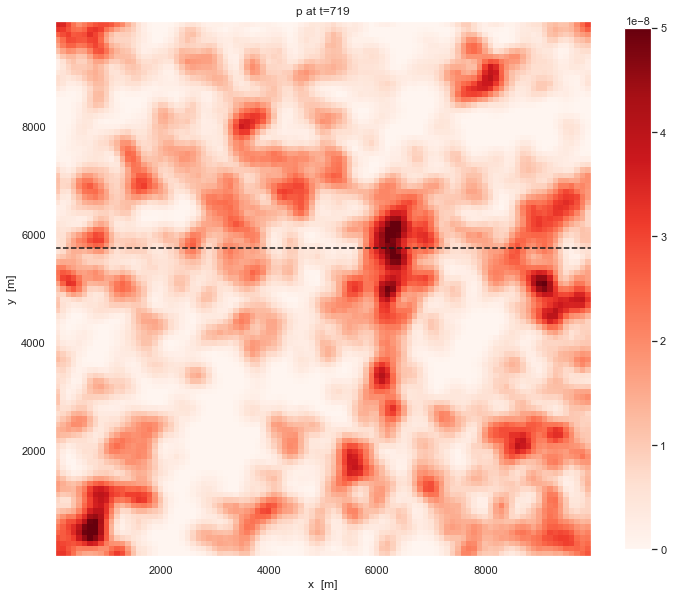

saved: p_thermals_movie_scat_dt719.pdf


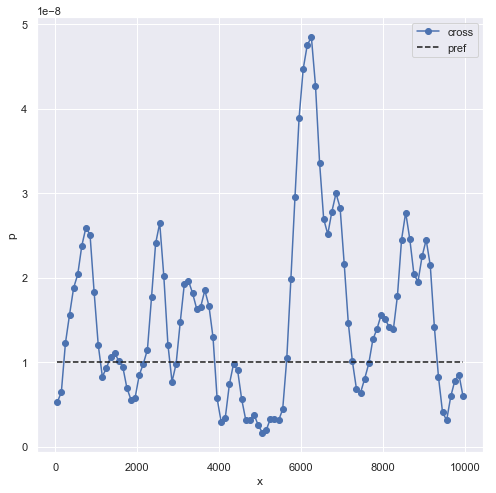

saved: p_thermals_movie_cross_dt719.pdf


In [235]:
t = ntim-1


#for l in range(1):
for l in range(len(siz)):
   
    
    #--- N(x,y) field  ---  
    fig = plt.figure(figsize=(12,12))

    axes = plt.gca()
    axes.set_aspect('equal')

    #cmap = plt.get_cmap('PiYG')
    cmap = plt.get_cmap('Reds')
    #cmap = plt.get_cmap('hsv')

    im = plt.pcolormesh(x,y,np.sum(N[:,:,l,t,:],axis=2), vmin=0,vmax=np.max(np.sum(N[:,:,l,t,:],axis=2)),cmap=cmap)
    CBI = plt.colorbar(im, shrink=0.8)

    plt.title("N(l=%s) at t=%s" % (l,t) )
    plt.xlabel("%s  [%s]" % ("x","m"))
    plt.ylabel("%s  [%s]" % ("y","m"))

    plt.close(fig)

    
    if pulse_growth_flag: 

        #--- 2D mesh plot of f_pulse  ---  
        fig = plt.figure(figsize=(6,6))

        axes = plt.gca()
        axes.set_aspect('equal')

        #cmap = plt.get_cmap('PiYG')
        cmap = plt.get_cmap('Reds')

        im = plt.pcolormesh(f_pulse, vmin=0,vmax=1,cmap=cmap)

        CBI = plt.colorbar(im, shrink=0.8)

        plt.title("f_pulse")

        plt.close(fig)


        #--- 2D mesh plot of p  ---  
        fig = plt.figure(figsize=(12,12))

        axes = plt.gca()
        axes.set_aspect('equal')

        #cmap = plt.get_cmap('PiYG')
        cmap = plt.get_cmap('Reds')

        #im = plt.pcolormesh(x,y,p[:,:,l,t], vmin=np.min(p[:,:,l,t]),vmax=np.max(p[:,:,l,t]),cmap=cmap)
        im = plt.pcolormesh(x,y,p[:,:,l,t], vmin=0.,vmax=5*prob_sub,cmap=cmap)

        #CBI = plt.colorbar(im, orientation='horizontal', shrink=0.8)
        CBI = plt.colorbar(im, shrink=0.8)

        plt.title("p at t=%s" % (t) )
        plt.xlabel("%s  [%s]" % ("x","m"))
        plt.ylabel("%s  [%s]" % ("y","m"))

        j=57
        plt.plot( [x[0],x[nx-1]], [y[j],y[j]], '--' , color='k',  label="cross")
        
        plt.show()                         # Show the figure

        #ext = ".png"
        ext = ".pdf"

        savestring ='p_thermals_movie_scat_dt'+str(t)+ext
        if t<100:
            savestring ='p_thermals_movie_scat_dt0'+str(t)+ext
        if t<10:
            savestring ='p_thermals_movie_scat_dt00'+str(t)+ext

        fig.savefig(savestring,bbox_inches = 'tight')
        print('saved: '+savestring)

        plt.close(fig)
        
        
        #--- cross-section through p field  ---  
        fig = plt.figure(figsize=(8,8))

        #plt.plot( x             , p[:,j,l,t]         , 'o-' ,           label="xcross")
        plt.plot( y             , p[j,:,l,t]         , 'o-' ,           label="cross")
        plt.plot( [x[0],x[nx-1]], [prob_sub,prob_sub], '--', color='k',label="pref")

        plt.xlabel('x')
        plt.ylabel('p')
        
        plt.legend()

        plt.show()

        #ext = ".png"
        ext = ".pdf"

        savestring ='p_thermals_movie_cross_dt'+str(t)+ext
        if t<100:
            savestring ='p_thermals_movie_cross_dt0'+str(t)+ext
        if t<10:
            savestring ='p_thermals_movie_cross_dt00'+str(t)+ext

        fig.savefig(savestring,bbox_inches = 'tight')
        print('saved: '+savestring)

        plt.close(fig)
        

        
        #--- 2D mesh plot of dp_pulse  ---  
        fig = plt.figure(figsize=(12,12))

        axes = plt.gca()
        axes.set_aspect('equal')

        #cmap = plt.get_cmap('PiYG')
        cmap = plt.get_cmap('Reds')

        im = plt.pcolormesh(x,y,dp_pulse, vmin=0,vmax=np.max(dp_pulse),cmap=cmap)

        CBI = plt.colorbar(im, shrink=0.8)

        plt.title("dp_pulse at t=%s" % (t) )
        plt.xlabel("%s  [%s]" % ("x","m"))
        plt.ylabel("%s  [%s]" % ("y","m"))

        plt.close(fig)


#plt.show()                         # Show the figure
#
#fig.savefig('plot_LV_2Dgrid_N.png', bbox_inches="tight")
#fig.savefig('plot_LV_2Dgrid_N.pdf', bbox_inches="tight")
#    
    
    

## Video maker

Raster plot of number of largest objects

In [103]:
#l=0
l=nsiz-1


#outdir_mov = 'mov/'
outdir_mov = 'mov_thermals/'


print('starting.. ')

#lets make a video, runs through all timesteps of N and makes a plot to later be made into a movie using ffmpeg, e.g.  ffmpeg -r 20 -i N_movie_dt%03d.png output_999.mp4
for t in range(0,ntim):
    
    #--- 2D mesh plot of the normalized N(x,y) field  ---  
    fig = plt.figure(figsize=(12,12))

    axes = plt.gca()
    axes.set_aspect('equal')

    #cmap = plt.get_cmap('PiYG')
    cmap = plt.get_cmap('Reds')
    cmap = plt.get_cmap('viridis')
    cmap = plt.get_cmap('magma')
    cmap = plt.get_cmap('hsv')
    cmap = plt.get_cmap('gist_ncar')
    cmap = plt.get_cmap('terrain')

    #im = plt.pcolormesh(x,y,np.sum(N[:,:,l,t,:],axis=2), vmin=1,vmax=np.max(np.sum(N[:,:,l,t,:],axis=2)),cmap=cmap)
    im = plt.pcolormesh(x,y,np.sum(N[:,:,l,t,:],axis=2), vmin=1,vmax=7,cmap=cmap)

    CBI = plt.colorbar(im, orientation='horizontal', shrink=0.8)

    plt.title("N at t=%s" % (t) )
    plt.xlabel("%s  [%s]" % ("x","m"))
    plt.ylabel("%s  [%s]" % ("y","m"))
    
    
    savestring ='N_thermals_movie_dt'+str(t)+'.png' 
    if t<100:
        savestring ='N_thermals_movie_dt0'+str(t)+'.png' 
    if t<10:
        savestring ='N_thermals_movie_dt00'+str(t)+'.png' 
    #if t<100:
    #    savestring ='N_movie_dt'+str(t)+'.png' 
        
    fig.savefig(outdir_mov+savestring,bbox_inches = 'tight')
    #print('saved: '+'mov/'+savestring)
    plt.close(fig)
    
    
print('saved: '+outdir_mov+savestring)


starting.. 
saved: mov/N_movie_dt719.png


# Clustering

I will cluster according to the number of samples/thermals/whatever in the last time output.
Results are ok, and look a lot like space invaders!

RN: Added threshold N value for clustering calculation

RN: Added time-loop, to calculate cluster info for each timestep

In [17]:
#l=0
l=nsiz-1


#Set N-threshold for clustering
N_crit = 1
#N_crit = 2

Npixel_largest = np.array(range(ntim))
Ntot           = np.array(range(ntim))
Ntot_lab       = np.array(range(ntim))

nbin = 39
sd_size_lin = np.empty((ntim,nbin))
sd_N_lin    = np.empty((ntim,nbin))

print('start clustering...')

for t in range(1,ntim):

    #Making a 2D binary field and clustering it with periodic boundary conditions
    N_final = np.sum( N[:,:,l,t,:], axis=2)
    binary_N = np.zeros_like(N_final)

    binary_N[N_final>N_crit] = 1

    labeled_N = cluster_2D(binary_N,buffer_size=20)
    
    if t==ntim2:
        binary_N_ntim2  = binary_N
        labeled_N_ntim2 = labeled_N     #store timepoint of interest

    labels, pixels = np.unique(labeled_N.ravel(),return_counts=True)
    
    if (np.size(pixels[1:])>0):
        Npixel_largest[t] = np.max(pixels[1:])
        Ntot          [t] = np.sum(N[:,:,l,t,:])
        Ntot_lab      [t] = np.sum(binary_N[:,:])

    #print( "  t=%s  time = %s" % (t, t*dtim), 'pixels of largest cluster: ',max(pixels[1:]))

    #-- size sorting --
    bins_lin2, ind_lin2, CSD_lin2 = lin_binner_minmax(pixels[1:] ,1,nbin+1,nbin)
    #print( (t,len(bins_lin2),len(CSD_lin2),len(sd_size_lin[t,:]))) 

    sd_size_lin[t,:] = np.sqrt(bins_lin2[1:])
    sd_N_lin   [t,:] = CSD_lin2
    
print('done')



start clustering...
done


# Convective memory

Timeseries of the number of pixels in the largest cluster on the grid

Steadily growing with time! Is this aggregation?

Also, this gradual increase is what we observe in diurnal cycles of cumulus over land (Thirza's paper). Even the time-scale of the increase is similar (over a few hours). Is this coincidence? I think not, we used constants that are inspired by convective thermals (size, radius of impact). What is still missing, of course, is other mechanisms (cloud latent heating, deepening of mixed layer, etc.) But for a first step, not bad..

Note 1: different experiments yield different time-series. However, what they all share is a gradual increase in max cluster size.

Note 2: Some kind of partial collapses seem to occur, typically after the occurrence of a very large cluster. What causes this "sudden memory loss"? Possibile explanation (not sure): Could be caused by the "dry patch" size approaching the domain size. As a result, one big congregation of clusters develops that starts to artificially reinforce itself (through rule 2) --> This would be an analogy with i) LES at too small domain size, and ii) aggregation of CRM in RCE (Muller and Held).


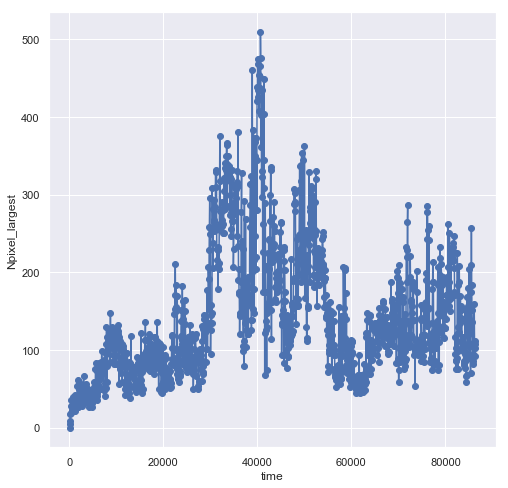

saved: N_thermals_movie_largest_dt1439.pdf


In [18]:
fig = plt.figure(figsize=(8,8))

plt.plot(tim,Npixel_largest,'o-')
plt.xlabel('time')
plt.ylabel('Npixel_largest')

plt.show()


#ext = ".png"
ext = ".pdf"

savestring ='N_thermals_movie_largest_dt'+str(t)+ext
if t<100:
    savestring ='N_thermals_movie_largest_dt0'+str(t)+ext
if t<10:
    savestring ='N_thermals_movie_largest_dt00'+str(t)+ext

fig.savefig(savestring,bbox_inches = 'tight')
print('saved: '+savestring)

plt.close(fig)


# For comparison: 

The total number of objects on the grid 

Quickly equilibrates, should be equal to B0. 

Expresses balance between grid-average birth and death rates.

Note: Rule 2 ensures this is the case, by making the cluster-environment more hostile for object births in such a way that grid-average p is conserved.

So this is not the same as convective memory, it expresses the constraint on B0 we impose.


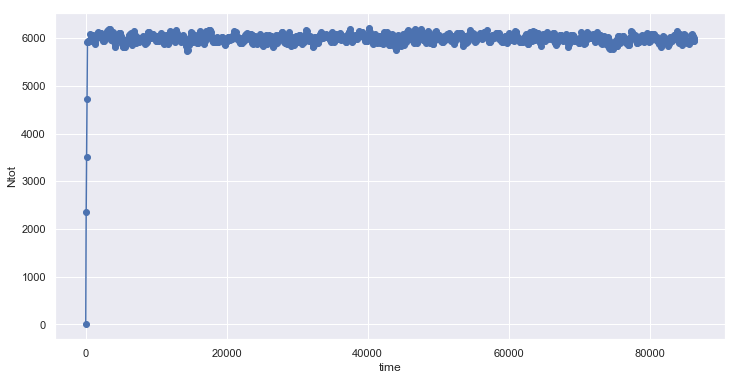

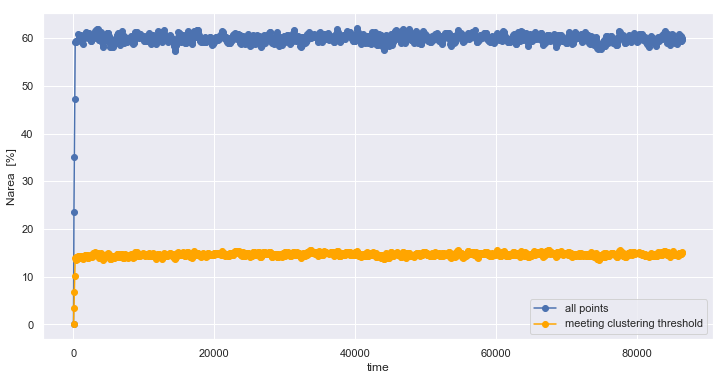

In [26]:
fig = plt.figure(figsize=(12,6))
plt.plot(tim,Ntot,'o-')
plt.xlabel('time')
plt.ylabel('Ntot')

plt.show() 


Narea     = 100. * Ntot    [:].astype(np.float) / (nx*ny)
Narea_lab = 100. * Ntot_lab[:].astype(np.float) / (nx*ny)
#print(Narea)

fig = plt.figure(figsize=(12,6))
plt.plot(tim,Narea    ,'o-',label='all points')
plt.plot(tim,Narea_lab,'o-',color='orange',label='meeting clustering threshold')

plt.xlabel('time')
plt.ylabel('Narea  [%]')

plt.legend()
plt.show()


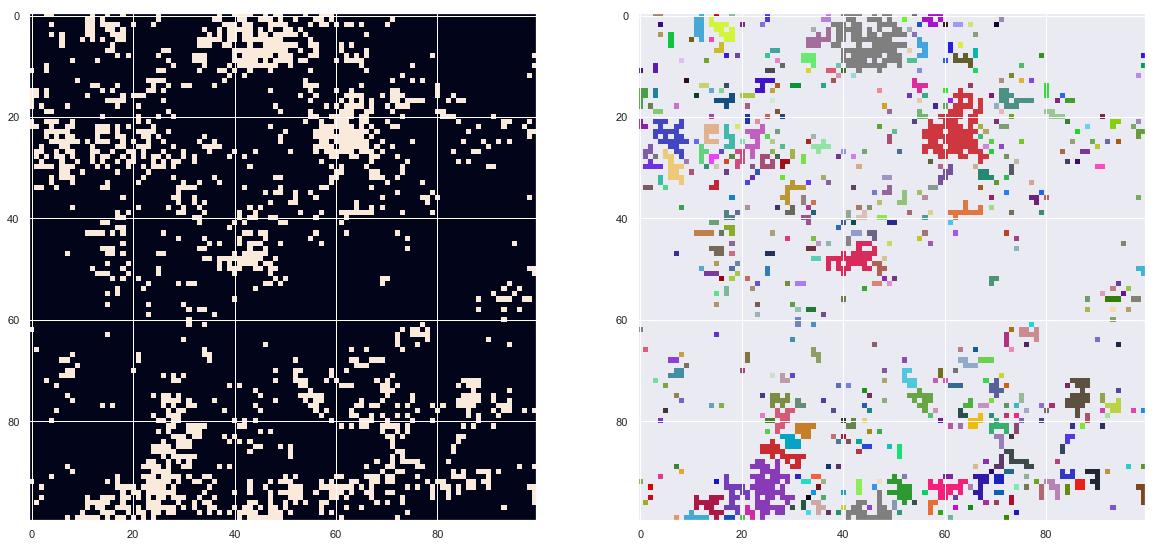

In [20]:
#Plotting binary field (left) and labled clusters (right)
masked_N = np.ma.masked_where(labeled_N_ntim2<1,labeled_N_ntim2)
fig,ax = plt.subplots(1,2,figsize=(20,10))
im1  =ax[0].imshow(binary_N_ntim2)
im1  =ax[1].imshow(masked_N,cmap=random_cmap)



## Population scatter plot including cluster info


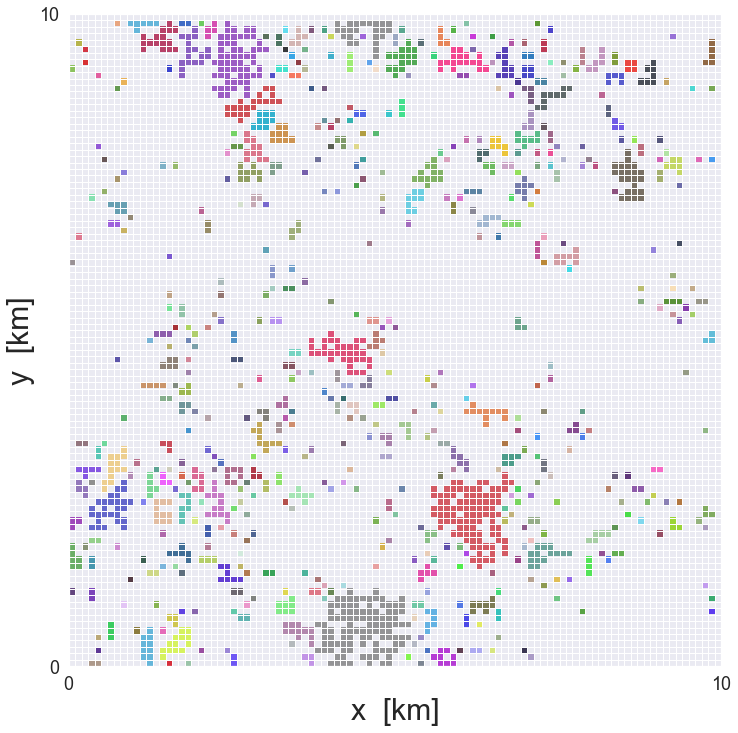

saved: N_thermals_movie_clust_dt1080.pdf


In [52]:
sizes = (siz*2)**2/1000
color = ['b','orange','r','g']

fig,axes = plt.subplots(1,1,figsize=(12,12))

axes.set_xlim([0.,(nx+1)*dx])
axes.set_ylim([0.,(ny+1)*dy])

axes.xaxis.set_major_locator(MultipleLocator(dx))
axes.yaxis.set_major_locator(MultipleLocator(dy))   #set gridspacing

labels = axes.get_xticklabels()
nxlab = len(labels)
#print( (nxlab,nx) )
xlab = np.empty( (nxlab) ).astype(np.str)
xlab[:] = ''
xlab[1      ] = '0'
xlab[nxlab-2] = '10'
#axes.set(yticklabels=xlab)
#axes.set(xticklabels=xlab)
axes.set_xticklabels(xlab, size = 18)
axes.set_yticklabels(xlab, size = 18)


#print(masked_N)
im = axes.imshow(masked_N,cmap=random_cmap,extent=(0.,(nx)*dx,(ny)*dy,0.), alpha=0.8 )

masked2_N = np.zeros_like(masked_N)
masked2_N[masked_N>=1] = 30
#print(masked2_N)
#im = axes.imshow(masked2_N,cmap=random_cmap,extent=(0.,(nx)*dx,(ny)*dy,0.), alpha=0.5 )


#-- uncomment this for adding the individual objects --
#for l in range(len(siz)):
#
#    ys, xs = func_scatter_grid( np.sum(N[:,:,l,t,:],axis=2) )
#    axes.scatter(dx*xs, dy*ys, s=sizes[l],c=color[l],alpha=0.5)


#plt.title("N at t=%s" % (t) )
plt.xlabel("%s  [%s]" % ("x","km"), fontsize=30)
plt.ylabel("%s  [%s]" % ("y","km"), fontsize=30)

plt.show()                         # Show the figure


#ext = ".png"
ext = ".pdf"

t=ntim2

savestring ='N_thermals_movie_clust_dt'+str(t)+ext
if t<100:
    savestring ='N_thermals_movie_clust_dt0'+str(t)+ext
if t<10:
    savestring ='N_thermals_movie_clust_dt00'+str(t)+ext

fig.savefig(savestring,bbox_inches = 'tight')
print('saved: '+savestring)


plt.close(fig)



# Getting the size of each cluster and binning

## first for log binning according to pixel number

## then linear binning of the root of pixel area

Includes super ugly basic plots

('pixels of largest cluster: ', 128)
('root of largest cluster number: ', 11.313708498984761)
('cloud size array, in pixels  : ', array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40.]))
('cloud size array av, sqrt of area   : ', array([1.41421356, 1.73205081, 2.        , 2.23606798, 2.44948974,
       2.64575131, 2.82842712, 3.        , 3.16227766, 3.31662479,
       3.46410162, 3.60555128, 3.74165739, 3.87298335, 4.        ,
       4.12310563, 4.24264069, 4.35889894, 4.47213595, 4.58257569,
       4.69041576, 4.79583152, 4.89897949, 5.        , 5.09901951,
       5.19615242, 5.29150262, 5.38516481, 5.47722558, 5.56776436,
       5.65685425, 5.74456265, 5.83095189, 5.91607978, 6.        ,
       6.08276253, 6.164414  , 6.244998  , 6.32455532]))


No handlers could be found for logger "matplotlib.legend"


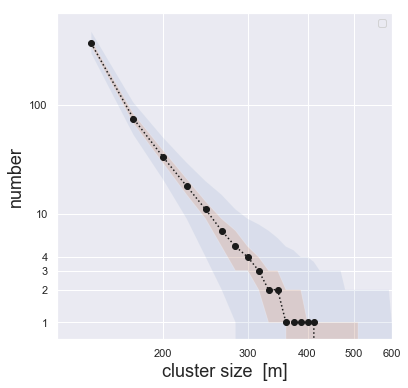

In [23]:
#--- determine the size of all clusters ---
labels, pixels = np.unique(labeled_N_ntim2.ravel(),return_counts=True)

print('pixels of largest cluster: ',max(pixels[1:]))
print('root of largest cluster number: ',max(np.sqrt(pixels[1:])))


#--- size-sort 'em --
bins_log , ind_log , CSD_log  = log_binner_minmax(        pixels[1:] ,1,150,10)
bins_lin , ind_lin , CSD_lin  = lin_binner_minmax(np.sqrt(pixels[1:]),1,15 ,14)
bins_lin2, ind_lin2, CSD_lin2 = lin_binner_minmax(        pixels[1:] ,1,40 ,39)

#print(labels)
#print(pixels)
#print(np.sqrt(pixels[1:]))

print('cloud size array, in pixels  : ',bins_lin2)
#print('cloud size density: ',CSD_lin2 )


#--- do some statistics ---

sd_size_lin_av  = np.average   ( sd_size_lin[1:,:]  , axis=0 )    #mean
print('cloud size array av, sqrt of area   : ',sd_size_lin_av)

dummy = np.where( np.isnan(sd_N_lin), 0, sd_N_lin)   #filter out nan's, set to zero

sd_N_lin_p01    = np.percentile( dummy[1:,:],  1., axis=0 )    #25% percentile
sd_N_lin_p25    = np.percentile( dummy[1:,:], 25., axis=0 )    #25% percentile
sd_N_lin_p50    = np.percentile( dummy[1:,:], 50., axis=0 )    #50% percentile
sd_N_lin_p75    = np.percentile( dummy[1:,:], 75., axis=0 )    #75% percentile
sd_N_lin_p99    = np.percentile( dummy[1:,:], 99., axis=0 )    #75% percentile


#--- percentile plot of the CSD ---
fig,ax = plt.subplots(1,1,figsize=(6,6))

#plt.plot(np.sqrt(bins_lin2[1:]),CSD_lin2,'o-',label="t=%s" % (t))

#for t in [10,100,ntim-1]:
#    plt.plot(sd_size_lin[t,:],sd_N_lin[t,:],'o-',label="t=%s" % (t))

ax.fill_between(sd_size_lin_av*dx, sd_N_lin_p01, sd_N_lin_p99, alpha=0.1)
ax.fill_between(sd_size_lin_av*dx, sd_N_lin_p25, sd_N_lin_p75, alpha=0.2)
ax.plot        (sd_size_lin_av*dx, sd_N_lin_p50, 'o:', color='k')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('cluster size  [m]', fontsize=18)
ax.set_ylabel('number', fontsize=18)

ax.set_xlim([120.,600.])
ax.set_ylim([.7,700.])
plt.setp(ax.get_yticklabels(which='minor'), visible=False)   #switch off the minor tickmarks

ax.set_xticks([200,300,400,500,600])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.setp(ax.get_xticklabels(which='minor'), visible=False)   #switch off the minor tickmarks

ax.set_yticks([1,2,3,4,10,100])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.legend()
    
plt.show()                         # Show the figure

fig.savefig('N_thermals_movie_CSD.png',bbox_inches = 'tight')
fig.savefig('N_thermals_movie_CSD.pdf',bbox_inches = 'tight')

plt.close(fig)



In [44]:
log_binner_minmax  #?

<function __main__.log_binner_minmax>

Text(0,0.5,u'distribution')

/usr/lib/python2.7/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


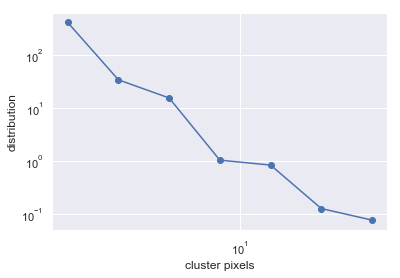

In [45]:
plt.plot(bins_log[1:]/2+bins_log[:-1],CSD_log,'o-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('cluster pixels')
plt.ylabel('distribution')

Text(0,0.5,u'distribution')

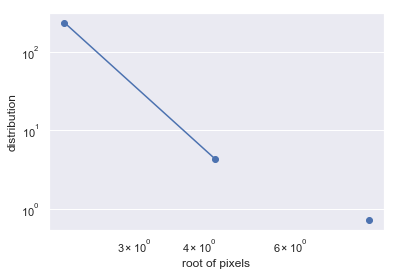

In [46]:
plt.plot(bins_lin[1:]/2+bins_lin[:-1],CSD_lin,'o-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('root of pixels')
plt.ylabel('distribution')

# Advection 

Advection function is defined above, this is just for running and plotting





In [14]:



#--- Grid parameters ----------
nx   = 15    #grid size
ny   = 15
nsiz = 4       #nr of sizes in spectrum
#ntim = 100     #nr of timesteps
ntim = 70    #nr of timesteps

dx   = 1000.    #x gridspacing     [m]
dy   = 1000.     #y gridspacing     [m]
dsiz = 100.    #width of size bin [m]
dtim = 60.     #time increment    [s]

#--- Reference domain
L_ref    = 1000000.   #size of very large reference domain  [m]
dt_ref   = dtim       #timestep of very large ref domain    [s]

#--- birth and lifetime constants --------
B_0  = np.zeros(nsiz)
B_0[:]    = 5.e-7   #average nr of object births / m2 / s

tau_D     = 300.    #object life time  [s]
tau_D_dt  = int(tau_D/dtim) #object life time in timesteps []


#--- pulsating growth parameters
pulse_growth_flag = 1
r_pulse   = 300.    #radius of impact cone of pulsating growth  [m]
fac_pulse =  20.    #factor of proportionality in impact of pulsating growth on p

#--- Advection parameters
u  = 5. #x wind, used for advection [m/s]
v  = 5. #y wind, used for advection [m/s]






#--- declare arrays -----------
x    = ( np.array(range(nx  )) + 0.5) * dx
y    = ( np.array(range(ny  )) + 0.5) * dy
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
tim  = ( np.array(range(ntim)) + 0.5) * dtim

N        = np.zeros( (nx,ny,nsiz,ntim) ).astype(int)    #array containing object number
p        = np.empty( (nx,ny,nsiz,ntim) )    #array containing object birth probability
dp_pulse = np.empty( (nx,ny) )    #perturbation in p due to pulsating growth (rule 1)






#--- binomial probability values -----------
N_tot_ref = np.zeros(nsiz)
N_tot_ref[:] = (B_0[:]*L_ref*L_ref*dt_ref).astype(int)  #total nr of objects born in reference domain
#print( N_tot_ref[0] )

prob_sub = dx*dy*dtim/(dt_ref*L_ref*L_ref)     #probability that one of N_tot_ref births happens in a gridbox
print( "prob_sub=%s" % (prob_sub) )

p       [:,:,:,:] = prob_sub

for i in range(len(siz)):
    print( "size=%s B0=%s N_tot_ref=%s" % (siz[i],B_0[i],N_tot_ref[i]) )

    
#--- set up pulsating growth stuff ---   
if pulse_growth_flag:
    nx_pulse = np.int( r_pulse / dx)
    ny_pulse = np.int( r_pulse / dy)

    f_pulse  = np.empty( (2 * nx_pulse + 1, 2 * ny_pulse + 1) )  

    #print( "nx_pulse=%s ny_pulse=%s" % (nx_pulse,ny_pulse) )
    #print( f_pulse.shape[0], f_pulse.shape[1] )

    for i in range(f_pulse.shape[0]):
        for j in range(f_pulse.shape[0]):
            f_pulse[i,j] = np.max( [0., 1. - ( (dx * (i - nx_pulse))**2 + (dy * (j - ny_pulse))**2 )**0.5 / r_pulse ] )

prob_sub=1e-06
size=50.0 B0=5e-07 N_tot_ref=30000000.0
size=150.0 B0=5e-07 N_tot_ref=30000000.0
size=250.0 B0=5e-07 N_tot_ref=30000000.0
size=350.0 B0=5e-07 N_tot_ref=30000000.0


In [15]:
# setting initial condition for advection, this time a square in the middle 

N[:,:,:,:] =0
#N[7:-7,7:-7,0,0]  = 1000
#N[7:-7,7:-7,1,0]  = 100
#N[7:-7,7:-7,2,0]  = 10
#N[7:-7,7:-7,3,0]  = 1
N[:5,:5,0,0]  = 10000
N[:5,:5,1,0]  = 100
N[:5,:5,2,0]  = 10
N[:5,:5,3,0]  = 1

#time loop
for t in range(ntim-1):
    for l in range(nsiz):
        N[:,:,l,t+1] = func_advection_binomial_2D(N[:,:,l,t],u*dtim/dx,v*dtim/dy)


Text(0, 0.5, 'y')

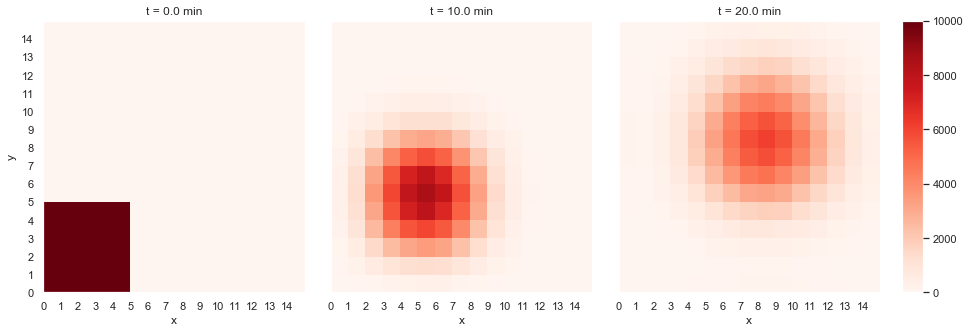

In [16]:
#pcolormesh for one l


plot_t = [0,10,20,]

l = 0
fig,axes = plt.subplots(1,len(plot_t),figsize=(5*len(plot_t),5),sharex=True,sharey=True)

#axes[0].add_patch(Rectangle((0,0),1,1,edgecolor='k',fill=False))
#axes[1].add_patch(Rectangle((1,1),1,1,edgecolor='k',fill=False))
#axes[2].add_patch(Rectangle((2,2),1,1,edgecolor='k',fill=False))
plt.rcParams["axes.axisbelow"] = False
vmax = np.max(N[:,:,l,plot_t])


ax_i = 0
for t in plot_t:
    ax = axes[ax_i]
    
    pmesh = ax.pcolormesh(N[:,:,l,t],cmap='Reds',vmax=vmax)
    
    # x, y = func_scatter_grid(N_sub_2[t,:,:])
    #ax.scatter(x,y,s=25,c='orange')
    #x, y = func_scatter_grid(N_sub_3[t,:,:])
    #ax.scatter(x,y,s=125,c='r')
    ax_i = ax_i+1
    #ax.plot(x_ref[:t+1]/1000.,y_ref[:t+1]/1000.,'ko-')
    ax.set_title('t = '+str(t*dtim/60)+' min')
    ax.set_xlabel('x')
    
    ax.set_xticks(np.arange(nx))
    ax.set_yticks(np.arange(ny))
    ax.grid(True,color='k',lw=1,alpha=0.5)
    
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.xlim(0,nx)
plt.ylim(0,ny)

# Add the colorbar outside...
box = axes[-1].get_position()
pad, width = 0.02, 0.02
cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])
fig.colorbar(pmesh, cax=cax)

axes[0].set_ylabel('y')



Text(0, 0.5, 'y')

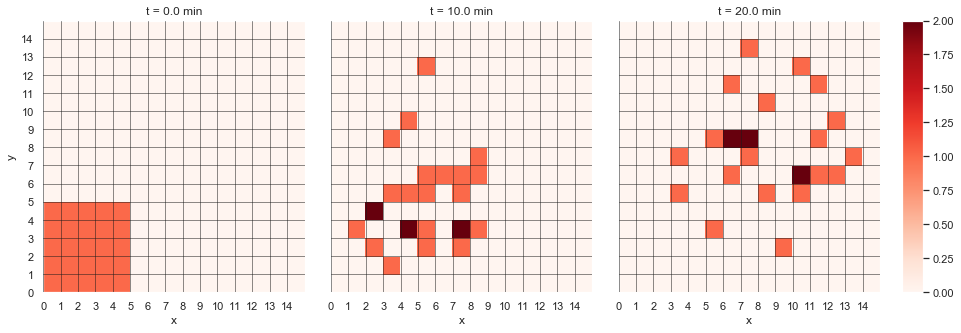

In [17]:
#pcolormesh for one l


plot_t = [0,10,20,]

l = 3
fig,axes = plt.subplots(1,len(plot_t),figsize=(5*len(plot_t),5),sharex=True,sharey=True)

#axes[0].add_patch(Rectangle((0,0),1,1,edgecolor='k',fill=False))
#axes[1].add_patch(Rectangle((1,1),1,1,edgecolor='k',fill=False))
#axes[2].add_patch(Rectangle((2,2),1,1,edgecolor='k',fill=False))
plt.rcParams["axes.axisbelow"] = False
vmax = np.max(N[:,:,l,plot_t])


ax_i = 0
for t in plot_t:
    ax = axes[ax_i]
    
    pmesh = ax.pcolormesh(N[:,:,l,t],cmap='Reds',vmax=vmax)
    
    # x, y = func_scatter_grid(N_sub_2[t,:,:])
    #ax.scatter(x,y,s=25,c='orange')
    #x, y = func_scatter_grid(N_sub_3[t,:,:])
    #ax.scatter(x,y,s=125,c='r')
    ax_i = ax_i+1
    #ax.plot(x_ref[:t+1]/1000.,y_ref[:t+1]/1000.,'ko-')
    ax.set_title('t = '+str(t*dtim/60)+' min')
    ax.set_xlabel('x')
    
    ax.set_xticks(np.arange(nx))
    ax.set_yticks(np.arange(ny))
    ax.grid(True,color='k',lw=1,alpha=0.5)
    
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.xlim(0,nx)
plt.ylim(0,ny)

# Add the colorbar outside...
box = axes[-1].get_position()
pad, width = 0.02, 0.02
cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])
fig.colorbar(pmesh, cax=cax)

axes[0].set_ylabel('y')



Text(0, 0.5, 'y')

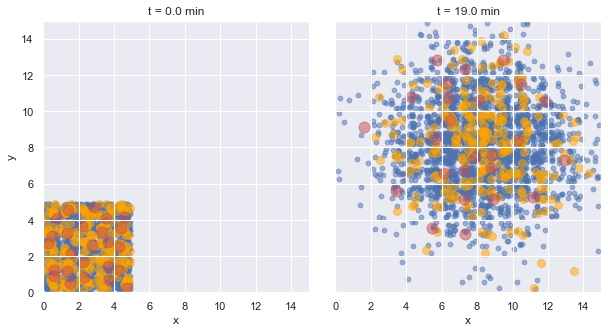

In [18]:
#fancy scatter plot with scatter for all sizes

plot_t = [0,19]
plot_l = [1,2,3]
fig,axes = plt.subplots(1,len(plot_t),figsize=(5*len(plot_t),5),sharex=True,sharey=True)

#axes[0].add_patch(Rectangle((0,0),1,1,edgecolor='k',fill=False))
#axes[1].add_patch(Rectangle((1,1),1,1,edgecolor='k',fill=False))
#axes[2].add_patch(Rectangle((2,2),1,1,edgecolor='k',fill=False))

#size
sizes = siz**2/1000
color = ['k','b','orange','r']
buff  = ['k','b','orange','r']

ax_i = 0
for t in plot_t:
    ax = axes[ax_i]
    
    for l in plot_l:
        #ax.add_patch(Rectangle((x_ref[t]/1000.-0.5,y_ref[t]/1000.-0.5),1,1,edgecolor='k',fill=False))
        x, y = func_scatter_grid(N[:,:,l,t])
        ax.scatter(x,y,s=sizes[l],c=color[l],alpha=0.5)
    
    # x, y = func_scatter_grid(N_sub_2[t,:,:])
    #ax.scatter(x,y,s=25,c='orange')
    #x, y = func_scatter_grid(N_sub_3[t,:,:])
    #ax.scatter(x,y,s=125,c='r')
    ax_i = ax_i+1
    #ax.plot(x_ref[:t+1]/1000.,y_ref[:t+1]/1000.,'ko-')
    ax.set_title('t = '+str(t*dtim/60)+' min')
    ax.set_xlabel('x')
    
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.xlim(0,nx)
plt.ylim(0,ny)


axes[0].set_ylabel('y')



In [19]:
# setting initial condition for advection, this time continous

#N[7:-7,7:-7,3,0]  = 1
N[:,:,0,0]  = 10000
N[:,:,1,0]  = 100
N[:,:,2,0]  = 10
N[:,:,3,0]  = 1

#time loop
for t in range(ntim-1):
    for l in range(nsiz):
        N[:,:,l,t+1] = func_advection_binomial_2D(N[:,:,l,t],u*dtim/dx,v*dtim/dy)


Text(0, 0.5, 'y')

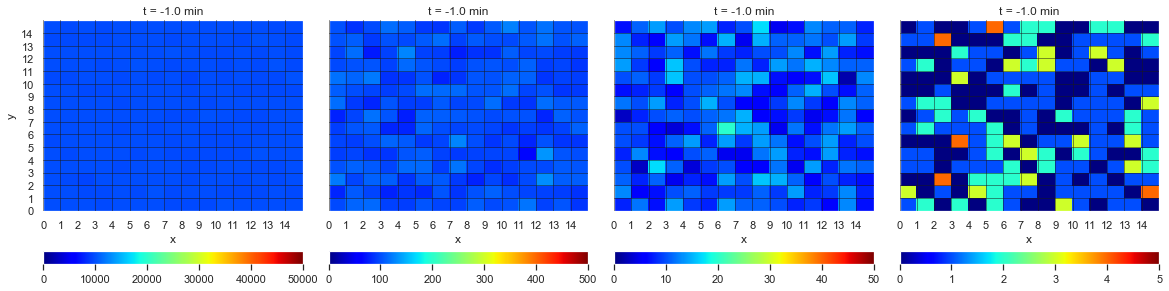

In [20]:
#pcolormesh for multiple l


plot_l = [0,1,2,3]

plot_t = -1
fig,axes = plt.subplots(1,len(plot_l),figsize=(5*len(plot_l),5),sharex=True,sharey=True)

#axes[0].add_patch(Rectangle((0,0),1,1,edgecolor='k',fill=False))
#axes[1].add_patch(Rectangle((1,1),1,1,edgecolor='k',fill=False))
#axes[2].add_patch(Rectangle((2,2),1,1,edgecolor='k',fill=False))
plt.rcParams["axes.axisbelow"] = False
vmax = np.max(N[:,:,plot_l,plot_t])

t = plot_t
ax_i = 0
for l in plot_l:
    ax = axes[ax_i]
    vmean = np.mean(N[:,:,l,t])
    vmax = np.max(N[:,:,l,t])
    vmin = vmean-(vmax-vmean)
    vmin = 0
    vmax = 5*vmean
    #pmesh = ax.pcolormesh(N[:,:,l,t],cmap='RdBu_r',vmin=vmin,vmax=vmax)
    pmesh = ax.pcolormesh(N[:,:,l,t],cmap='jet',vmin=vmin,vmax=vmax)
    # x, y = func_scatter_grid(N_sub_2[t,:,:])
    #ax.scatter(x,y,s=25,c='orange')
    #x, y = func_scatter_grid(N_sub_3[t,:,:])
    #ax.scatter(x,y,s=125,c='r')
    ax_i = ax_i+1
    #ax.plot(x_ref[:t+1]/1000.,y_ref[:t+1]/1000.,'ko-')
    ax.set_title('t = '+str(t*dtim/60)+' min')
    ax.set_xlabel('x')
    
    ax.set_xticks(np.arange(nx))
    ax.set_yticks(np.arange(ny))
    ax.grid(True,color='k',lw=1,alpha=0.5)
    
    fig.colorbar(pmesh,orientation='horizontal',ax=ax)
    
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.xlim(0,nx)
plt.ylim(0,ny)

# Add the colorbar outside...
box = axes[-1].get_position()
pad, width = 0.02, 0.02
#cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])
#fig.colorbar(pmesh, cax=cax)

axes[0].set_ylabel('y')



# Not yet finished advection plotting stuff

In [27]:



#--- Grid parameters ----------
nx   = 5    #grid size
ny   = 5
nsiz = 4       #nr of sizes in spectrum
#ntim = 100     #nr of timesteps
ntim = 20    #nr of timesteps

dx   = 1000.    #x gridspacing     [m]
dy   = 1000.     #y gridspacing     [m]
dsiz = 100.    #width of size bin [m]
dtim = 60.     #time increment    [s]

#--- Reference domain
L_ref    = 1000000.   #size of very large reference domain  [m]
dt_ref   = dtim       #timestep of very large ref domain    [s]

#--- birth and lifetime constants --------
B_0  = np.zeros(nsiz)
B_0[:]    = 5.e-7   #average nr of object births / m2 / s

tau_D     = 300.    #object life time  [s]
tau_D_dt  = int(tau_D/dtim) #object life time in timesteps []


#--- pulsating growth parameters
pulse_growth_flag = 1
r_pulse   = 300.    #radius of impact cone of pulsating growth  [m]
fac_pulse =  20.    #factor of proportionality in impact of pulsating growth on p

#--- Advection parameters
u  = 5. #x wind, used for advection [m/s]
v  = 5. #y wind, used for advection [m/s]






#--- declare arrays -----------
x    = ( np.array(range(nx  )) + 0.5) * dx
y    = ( np.array(range(ny  )) + 0.5) * dy
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
tim  = ( np.array(range(ntim)) + 0.5) * dtim

N        = np.zeros( (nx,ny,nsiz,ntim) ).astype(int)    #array containing object number
p        = np.empty( (nx,ny,nsiz,ntim) )    #array containing object birth probability
dp_pulse = np.empty( (nx,ny) )    #perturbation in p due to pulsating growth (rule 1)






#--- binomial probability values -----------
N_tot_ref = np.zeros(nsiz)
N_tot_ref[:] = (B_0[:]*L_ref*L_ref*dt_ref).astype(int)  #total nr of objects born in reference domain
#print( N_tot_ref[0] )

prob_sub = dx*dy*dtim/(dt_ref*L_ref*L_ref)     #probability that one of N_tot_ref births happens in a gridbox
print( "prob_sub=%s" % (prob_sub) )

p       [:,:,:,:] = prob_sub

for i in range(len(siz)):
    print( "size=%s B0=%s N_tot_ref=%s" % (siz[i],B_0[i],N_tot_ref[i]) )

    
#--- set up pulsating growth stuff ---   
if pulse_growth_flag:
    nx_pulse = np.int( r_pulse / dx)
    ny_pulse = np.int( r_pulse / dy)

    f_pulse  = np.empty( (2 * nx_pulse + 1, 2 * ny_pulse + 1) )  

    #print( "nx_pulse=%s ny_pulse=%s" % (nx_pulse,ny_pulse) )
    #print( f_pulse.shape[0], f_pulse.shape[1] )

    for i in range(f_pulse.shape[0]):
        for j in range(f_pulse.shape[0]):
            f_pulse[i,j] = np.max( [0., 1. - ( (dx * (i - nx_pulse))**2 + (dy * (j - ny_pulse))**2 )**0.5 / r_pulse ] )

prob_sub=1e-06
size=50.0 B0=5e-07 N_tot_ref=30000000.0


Text(0, 0.5, 'y')

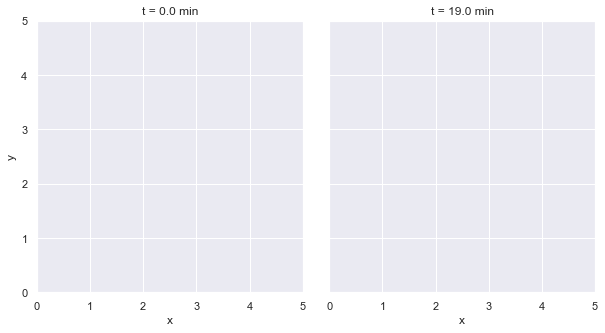

In [40]:
#fancy scatter plot with scatter for all sizes

plot_t = [0,19]
plot_l = [1,2,3]
fig,axes = plt.subplots(1,len(plot_t),figsize=(5*len(plot_t),5),sharex=True,sharey=True)

#axes[0].add_patch(Rectangle((0,0),1,1,edgecolor='k',fill=False))
#axes[1].add_patch(Rectangle((1,1),1,1,edgecolor='k',fill=False))
#axes[2].add_patch(Rectangle((2,2),1,1,edgecolor='k',fill=False))

#size
sizes = siz**2/1000
color = ['k','b','orange','r']
buff  = ['k','b','orange','r']

ax_i = 0
for t in plot_t:
    ax = axes[ax_i]
    
    for l in plot_l:
        #ax.add_patch(Rectangle((x_ref[t]/1000.-0.5,y_ref[t]/1000.-0.5),1,1,edgecolor='k',fill=False))
        x, y = func_scatter_grid(N[:,:,l,t])
        ax.scatter(x,y,s=sizes[l],c=color[l],alpha=0.5)
    
    # x, y = func_scatter_grid(N_sub_2[t,:,:])
    #ax.scatter(x,y,s=25,c='orange')
    #x, y = func_scatter_grid(N_sub_3[t,:,:])
    #ax.scatter(x,y,s=125,c='r')
    ax_i = ax_i+1
    #ax.plot(x_ref[:t+1]/1000.,y_ref[:t+1]/1000.,'ko-')
    ax.set_title('t = '+str(t*dtim/60)+' min')
    ax.set_xlabel('x')
    
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.xlim(0,nx)
plt.ylim(0,ny)


axes[0].set_ylabel('y')



In [39]:
#Lets get started on a 2D grid right away, with N_step timesteps in the third dimension
n_width  = 5
n_height = 5
n_time   = 100


N_sub_0 = np.zeros([n_time+1,n_width,n_height]).astype(int)
N_sub_1 = np.zeros([n_time+1,n_width,n_height]).astype(int)
N_sub_2 = np.zeros([n_time+1,n_width,n_height]).astype(int)
N_sub_3 = np.zeros([n_time+1,n_width,n_height]).astype(int)

#Initialize a starting population
N_sub_0[0,0,0] = 20000
N_sub_1[0,0,0] = 2000
N_sub_2[0,0,0] = 20
N_sub_3[0,0,0] = 2

#Define dimensions in m
dx = 1000
dy = 1000

#Horitontal wind in m/s
#Now set so that the grid box moves 1 km every 10 minutes
v_x = 1000/600
v_y = 1000/600

dt = 60

#Ref 
x_ref = np.zeros(n_time+1)
y_ref = np.zeros(n_time+1)
x_ref[0] = dx/2.
y_ref[0] = dx/2.

#time loop
for t in range(n_time):
    N_sub_0[t+1,:,:] = func_advection_binomial_2D(N_sub_1[t,:,:],v_x*dt/dx,v_y*dt/dy)
    N_sub_1[t+1,:,:] = func_advection_binomial_2D(N_sub_1[t,:,:],v_x*dt/dx,v_y*dt/dy)
    N_sub_2[t+1,:,:] = func_advection_binomial_2D(N_sub_2[t,:,:],v_x*dt/dx,v_y*dt/dy)
    N_sub_3[t+1,:,:] = func_advection_binomial_2D(N_sub_3[t,:,:],v_x*dt/dx,v_y*dt/dy)
    x_ref[t+1]=x_ref[t]+dt*v_x
    y_ref[t+1]=y_ref[t]+dt*v_y

In [93]:
N_sub_1_v1 = N_sub_1
N_sub_2_v1 = N_sub_2
N_sub_3_v1 = N_sub_3
x_ref_v1 = x_ref
y_ref_v1 = y_ref
dt_v1 = dt

In [53]:
#Lets get started on a 2D grid right away, with N_step timesteps in the third dimension
n_width  = 5
n_height = 5
n_time   = 100


N_sub_0 = np.zeros([n_time+1,n_width,n_height]).astype(int)
N_sub_1 = np.zeros([n_time+1,n_width,n_height]).astype(int)
N_sub_2 = np.zeros([n_time+1,n_width,n_height]).astype(int)
N_sub_3 = np.zeros([n_time+1,n_width,n_height]).astype(int)

#Initialize a starting population
N_sub_0[0,0,0] = 20000
N_sub_1[0,0,0] = 2000
N_sub_2[0,0,0] = 20
N_sub_3[0,0,0] = 2

#Define dimensions in m
dx = 1000
dy = 1000

#Horitontal wind in m/s
#Now set so that the grid box moves 1 km every 10 minutes
v_x = 1000/600
v_y = 1000/600

dt = 60*5

#Ref 
x_ref = np.zeros(n_time+1)
y_ref = np.zeros(n_time+1)
x_ref[0] = dx/2.
y_ref[0] = dx/2.

#time loop
for t in range(n_time):
    N_sub_0[t+1,:,:] = func_advection_binomial_2D(N_sub_1[t,:,:],v_x*dt/dx,v_y*dt/dy,periodic_flag=False)
    N_sub_1[t+1,:,:] = func_advection_binomial_2D(N_sub_1[t,:,:],v_x*dt/dx,v_y*dt/dy,periodic_flag=False)
    N_sub_2[t+1,:,:] = func_advection_binomial_2D(N_sub_2[t,:,:],v_x*dt/dx,v_y*dt/dy,periodic_flag=False)
    N_sub_3[t+1,:,:] = func_advection_binomial_2D(N_sub_3[t,:,:],v_x*dt/dx,v_y*dt/dy,periodic_flag=False)
    x_ref[t+1]=x_ref[t]+dt*v_x
    y_ref[t+1]=y_ref[t]+dt*v_y

In [49]:
N_sub_1_v5 = N_sub_1
N_sub_2_v5 = N_sub_2
N_sub_3_v5 = N_sub_3
x_ref_v5 = x_ref
y_ref_v5 = y_ref
dt_v5 = dt

Text(0.5, 0, 'x in km')

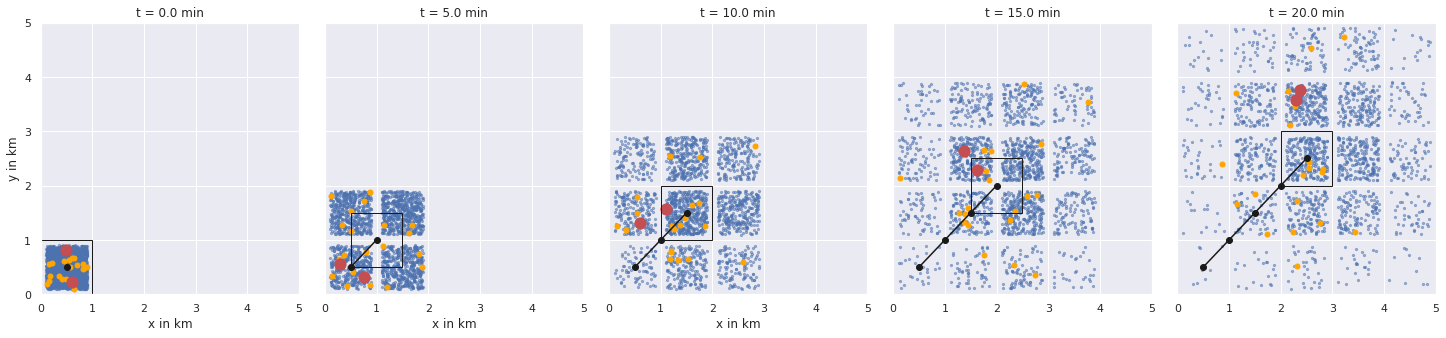

In [50]:
plot_t = [0,1,2,3,4]
fig,axes = plt.subplots(1,len(plot_t),figsize=(5*len(plot_t),5),sharex=True,sharey=True)

#axes[0].add_patch(Rectangle((0,0),1,1,edgecolor='k',fill=False))
#axes[1].add_patch(Rectangle((1,1),1,1,edgecolor='k',fill=False))
#axes[2].add_patch(Rectangle((2,2),1,1,edgecolor='k',fill=False))

ax_i = 0
for t in plot_t:
    ax = axes[ax_i] 
    ax.add_patch(Rectangle((x_ref[t]/1000.-0.5,y_ref[t]/1000.-0.5),1,1,edgecolor='k',fill=False))
    x, y = func_scatter_grid(N_sub_1[t,:,:])
    ax.scatter(x,y,s=5,c='b',alpha=0.5)
    x, y = func_scatter_grid(N_sub_2[t,:,:])
    ax.scatter(x,y,s=25,c='orange')
    x, y = func_scatter_grid(N_sub_3[t,:,:])
    ax.scatter(x,y,s=125,c='r')
    ax_i = ax_i+1
    ax.plot(x_ref[:t+1]/1000.,y_ref[:t+1]/1000.,'ko-')
    ax.set_title('t = '+str(t*dt/60)+' min')
    
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.xlim(0,n_width)
plt.ylim(0,n_height)

axes[0].set_ylabel('y in km')
axes[1].set_xlabel('x in km')
axes[2].set_xlabel('x in km')
axes[0].set_xlabel('x in km')



Text(0.5, 0, 'x in km')

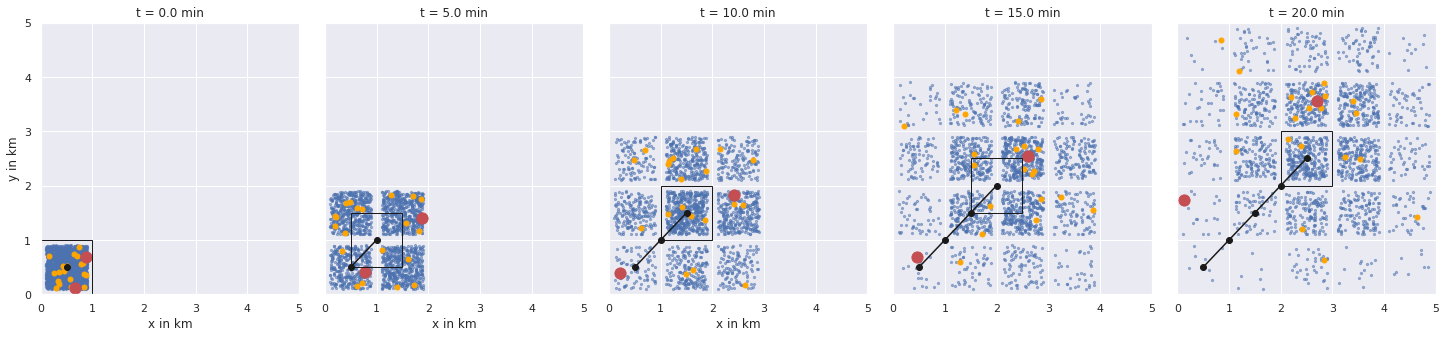

In [54]:
plot_t = [0,1,2,3,4]
fig,axes = plt.subplots(1,len(plot_t),figsize=(5*len(plot_t),5),sharex=True,sharey=True)

#axes[0].add_patch(Rectangle((0,0),1,1,edgecolor='k',fill=False))
#axes[1].add_patch(Rectangle((1,1),1,1,edgecolor='k',fill=False))
#axes[2].add_patch(Rectangle((2,2),1,1,edgecolor='k',fill=False))

ax_i = 0
for t in plot_t:
    ax = axes[ax_i] 
    ax.add_patch(Rectangle((x_ref[t]/1000.-0.5,y_ref[t]/1000.-0.5),1,1,edgecolor='k',fill=False))
    x, y = func_scatter_grid(N_sub_1[t,:,:])
    ax.scatter(x,y,s=5,c='b',alpha=0.5)
    x, y = func_scatter_grid(N_sub_2[t,:,:])
    ax.scatter(x,y,s=25,c='orange')
    x, y = func_scatter_grid(N_sub_3[t,:,:])
    ax.scatter(x,y,s=125,c='r')
    ax_i = ax_i+1
    ax.plot(x_ref[:t+1]/1000.,y_ref[:t+1]/1000.,'ko-')
    ax.set_title('t = '+str(t*dt/60)+' min')
    
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.xlim(0,n_width)
plt.ylim(0,n_height)

axes[0].set_ylabel('y in km')
axes[1].set_xlabel('x in km')
axes[2].set_xlabel('x in km')
axes[0].set_xlabel('x in km')



In [170]:
#Lets get started on a 2D grid right away, with N_step timesteps in the third dimension
n_width  = 5
n_height = 5
n_time   = 100


N_sub_0 = np.zeros([n_time+1,n_width,n_height]).astype(int)
N_sub_1 = np.zeros([n_time+1,n_width,n_height]).astype(int)
N_sub_2 = np.zeros([n_time+1,n_width,n_height]).astype(int)
N_sub_3 = np.zeros([n_time+1,n_width,n_height]).astype(int)

#Initialize a starting population
N_sub_0[0,0,0] = 20000
N_sub_1[0,0,0] = 2000
N_sub_2[0,0,0] = 20
N_sub_3[0,0,0] = 2

#Define dimensions in m
dx = 1000
dy = 1000

#Horitontal wind in m/s
#Now set so that the grid box moves 1 km every 10 minutes
v_x = 1000/600
v_y = 1000/600

dt = 60*10

#Ref 
x_ref = np.zeros(n_time+1)
y_ref = np.zeros(n_time+1)
x_ref[0] = dx/2.
y_ref[0] = dx/2.

#time loop
for t in range(n_time):
    N_sub_0[t+1,:,:] = func_advection_binomial_2D(N_sub_1[t,:,:],v_x*dt/dx,v_y*dt/dy)
    N_sub_1[t+1,:,:] = func_advection_binomial_2D(N_sub_1[t,:,:],v_x*dt/dx,v_y*dt/dy)
    N_sub_2[t+1,:,:] = func_advection_binomial_2D(N_sub_2[t,:,:],v_x*dt/dx,v_y*dt/dy)
    N_sub_3[t+1,:,:] = func_advection_binomial_2D(N_sub_3[t,:,:],v_x*dt/dx,v_y*dt/dy)
    x_ref[t+1]=x_ref[t]+dt*v_x
    y_ref[t+1]=y_ref[t]+dt*v_y

In [171]:
N_sub_1_v10 = N_sub_1
N_sub_2_v10 = N_sub_2
N_sub_3_v10 = N_sub_3
x_ref_v10 = x_ref
y_ref_v10 = y_ref
dt_v10 = dt

In [21]:
np.array(range(nx/10)) * 10


array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [160]:
print(binary_N)

binary_N = 

[[0 1 1 ... 0 0 1]
 [0 1 0 ... 0 1 1]
 [1 1 1 ... 0 1 0]
 ...
 [1 1 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 1]]
